In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

%matplotlib inline

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

# Helper Functions & Initialising Scripts

In [2]:
def tracking_error(benchmark : pd.Series, portfolio : pd.Series) -> float:
    '''
        Function to compute tracking error
    '''
    return (portfolio - benchmark).std()

def annualised_vol(ret):
    '''
        Function to convert daily volatility to annualised volatility
    '''
    return ret.std()*np.sqrt(252)

def annualised_ret(ret):
    return (1+ret).prod()**(1/252)-1

def sharpe_ratio (ret):
    return annualised_ret(ret)/annualised_vol(ret)

def drawdown(ret):
    wealth_index = (1+ret).cumprod()
    previous_peak = wealth_index.cummax()
    drawdowns = ((wealth_index - previous_peak)/ previous_peak)
    return pd.DataFrame ({
        "wealth": wealth_index,
        "peak": previous_peak,
        "drawdown": drawdowns   
                         })

In [3]:
# %run -i 'portfolio.py'
prt = __import__("portfolio")
Portfolio = getattr(prt, "Portfolio")

# Read Portfolios and trading Strategies

Choosing the following ETFs for each asset class:
<table>
    <th>
        <td>Ticker</td>
        <td>Weight</td>
        <td>Ticker Description</td>
    </th>
    <tr>
        <td>US Market</td>
        <td><b>SPY</b></td>
        <td>30%</td>
        <td>S&P 500 ETF</td>
    </tr>
    <tr>
        <td>International Markets (ex. US)</td>
        <td><b>ACWX</b></td>
        <td>25%</td>
        <td>MSCI Asian/Emerging Markets ex U.S. ETF</td>
    </tr>
    <tr>
        <td>US Bonds</td>
        <td><b>SCHO</b></td>
        <td>20%</td>
        <td>Schwab Short Term US Treasury ETF</td>
    </tr>
    <tr>
        <td>International Bonds</td>
        <td><b>BNDX</b></td>
        <td>15%</td>
        <td>Vanguard Total International Bond Index Fund ETF Shares</td>
    </tr>
    <tr>
        <td>Other Asset Classes</td>
        <td><b>USO</b></td>
        <td>10%</td>
        <td>United States Oil Fund, LP</td>
    </tr>
</table>

In [4]:
start_date = pd.to_datetime("2010-01-01")
end_date = pd.to_datetime("2020-12-31")
portfolio_tickers = ["SPY","ACWX","SCHO","PICB","USO"]
# portfolio_tickers = ["SPY","ACWX","SCHO","PICB","GLD"]

In [5]:
ticker_set = dict()
for year in range(start_date.year,end_date.year+1):
    ticker_set[year] = portfolio_tickers
ticker_set

{2010: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2011: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2012: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2013: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2014: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2015: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2016: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2017: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2018: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2019: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO'],
 2020: ['SPY', 'ACWX', 'SCHO', 'PICB', 'USO']}

## WRDS csv Data

## WRDS API

## Yahoo API

In [6]:
stocks = yf.Tickers(" ".join(portfolio_tickers))
benchmark_weights = pd.Series([0.30, 0.25, 0.20, 0.15, 0.10], index= portfolio_tickers)
benchmark_weights

SPY     0.30
ACWX    0.25
SCHO    0.20
PICB    0.15
USO     0.10
dtype: float64

[*********************100%***********************]  5 of 5 completed


close                                               div       \
                 ACWX       PICB       SCHO        SPY         USO ACWX PICB   
Date                                                                           
2010-08-05  30.169270  21.334187  45.387035  90.621956  293.679993  0.0  0.0   
2010-08-06  30.161728  21.536852  45.414284  90.252556  289.600006  0.0  0.0   
2010-08-09  30.244635  21.435518  45.387035  90.734383  292.239990  0.0  0.0   
2010-08-10  30.018532  21.380970  45.414284  90.244560  286.959991  0.0  0.0   
2010-08-11  28.729757  21.131531  45.414284  87.771202  277.920013  0.0  0.0   

                         shares                     
           SCHO  SPY USO    SPY ACWX SCHO PICB USO  
Date                                                
2010-08-05  0.0  0.0   0      1    1    1    1   1  
2010-08-06  0.0  0.0   0      1    1    1    1   1  
2010-08-09  0.0  0.0   0      1    1    1    1   1  
2010-08-10  0.0  0.0   0      1    1    1    1   1  
2010-08-11  0.0  0.0   0      1    1    1    1   1

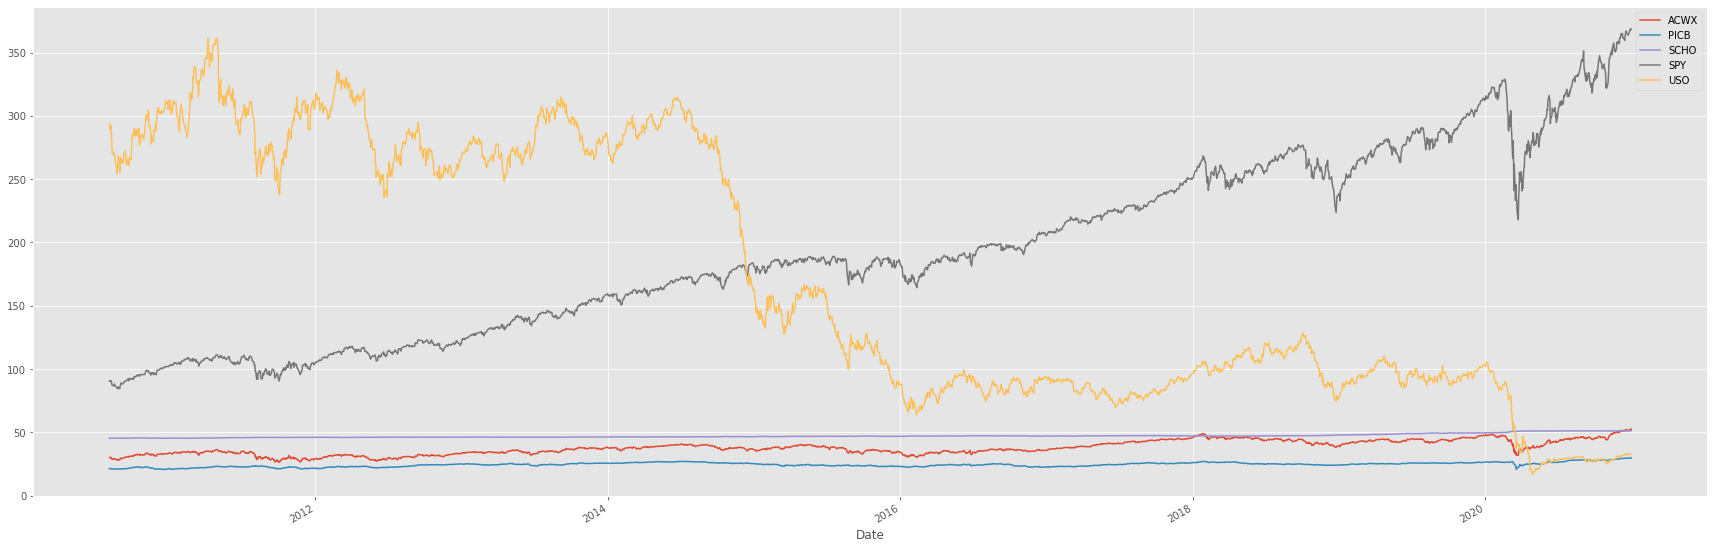

In [7]:
stock_data = stocks.download(" ".join(portfolio_tickers), start=start_date, end=end_date)[["Close","Dividends"]].dropna()
stock_data.rename({"Close":"close","Dividends":"div"}, axis  =1, inplace= True)
stock_data["close"].plot(figsize = (30,10))
# stock_data.head()

for tic in portfolio_tickers:
    stock_data[("shares", tic)] = pd.Series([1]*len(stock_data.index), index= stock_data.index)

stock_data.head()

# BenchMark Portfolio

In [8]:
benchmark_portfolio = Portfolio(target="Baseline",
                        tickerset= ticker_set, investment= 100,
                        trading_algo= "constant_weight_Algo",
                        rebalance=1, reconstitute=100)

benchmark_portfolio.echo()

Building Portfolios and Initialising Trading Algorithms
Target Index: Baseline
Trading Algorithm: Asset Class Weighted (Constant)
Starting Investment: 100
Current Investment: 100


In [9]:
benchmark_val = pd.Series([], dtype=float)
benchmark_returns = pd.Series([], dtype=float)

for date in stock_data.index:
    tmpdf = stock_data.loc[date]
    tmpdf = tmpdf.unstack().T
    valuation, returns =  benchmark_portfolio.run(date= date, price= tmpdf, tickerlist = portfolio_tickers)
    if (valuation, returns) == (-1,-1):
        print(benchmark_val)
        print(benchmark_val.index[-1],date.date(), valuation, returns)
        continue
    benchmark_val[date] = valuation
    benchmark_returns[date] = returns

Reconstitution on: 05-Aug-2010
	Rebalancing on: 05-Aug-2010
	Rebalancing on: 01-Sep-2010
	Rebalancing on: 01-Oct-2010
	Rebalancing on: 01-Nov-2010
	Rebalancing on: 01-Dec-2010
	Rebalancing on: 03-Jan-2011
	Rebalancing on: 01-Feb-2011
	Rebalancing on: 01-Mar-2011
	Rebalancing on: 01-Apr-2011
	Rebalancing on: 02-May-2011
	Rebalancing on: 01-Jun-2011
	Rebalancing on: 01-Jul-2011
	Rebalancing on: 01-Aug-2011
	Rebalancing on: 01-Sep-2011
	Rebalancing on: 03-Oct-2011
	Rebalancing on: 01-Nov-2011
	Rebalancing on: 01-Dec-2011
	Rebalancing on: 03-Jan-2012
	Rebalancing on: 01-Feb-2012
	Rebalancing on: 01-Mar-2012
	Rebalancing on: 02-Apr-2012
	Rebalancing on: 01-May-2012
	Rebalancing on: 01-Jun-2012
	Rebalancing on: 02-Jul-2012
	Rebalancing on: 01-Aug-2012
	Rebalancing on: 04-Sep-2012
	Rebalancing on: 01-Oct-2012
	Rebalancing on: 01-Nov-2012
	Rebalancing on: 03-Dec-2012
	Rebalancing on: 02-Jan-2013
	Rebalancing on: 01-Feb-2013
	Rebalancing on: 01-Mar-2013
	Rebalancing on: 01-Apr-2013
	Rebalancing

## Plot

In [10]:
# fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
# fig.set_size_inches(30, 10,  forward=True)

# ax[0].plot(benchmark_val, label = ["Benchmark"])
# ax[1].plot(benchmark_returns, label = ["Benchmark"])

# for tic in portfolio_tickers:
#     ax[0].plot(stock_data[("close",tic)], label = tic)
#     ax[1].plot(stock_data[("close", tic)].pct_change(), alpha = 0.5, label = tic)


# ax[0].set_xlabel("Time")
# ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
# ax[0].set_title("Portfolio v/s benchmarks - Valuation")

# ax[1].set_xlabel("Time")
# ax[1].set_ylabel("Portfolio Daily Returns")
# ax[1].set_title("Portfolio v/s benchmarks - Returns")

# ax[0].legend(["Portfolio Value"]+ portfolio_tickers)
# ax[1].legend(["Portfolio Returns"]+ portfolio_tickers)

# fig.suptitle('S&P 500 Replicating Portfolio',fontsize=20);

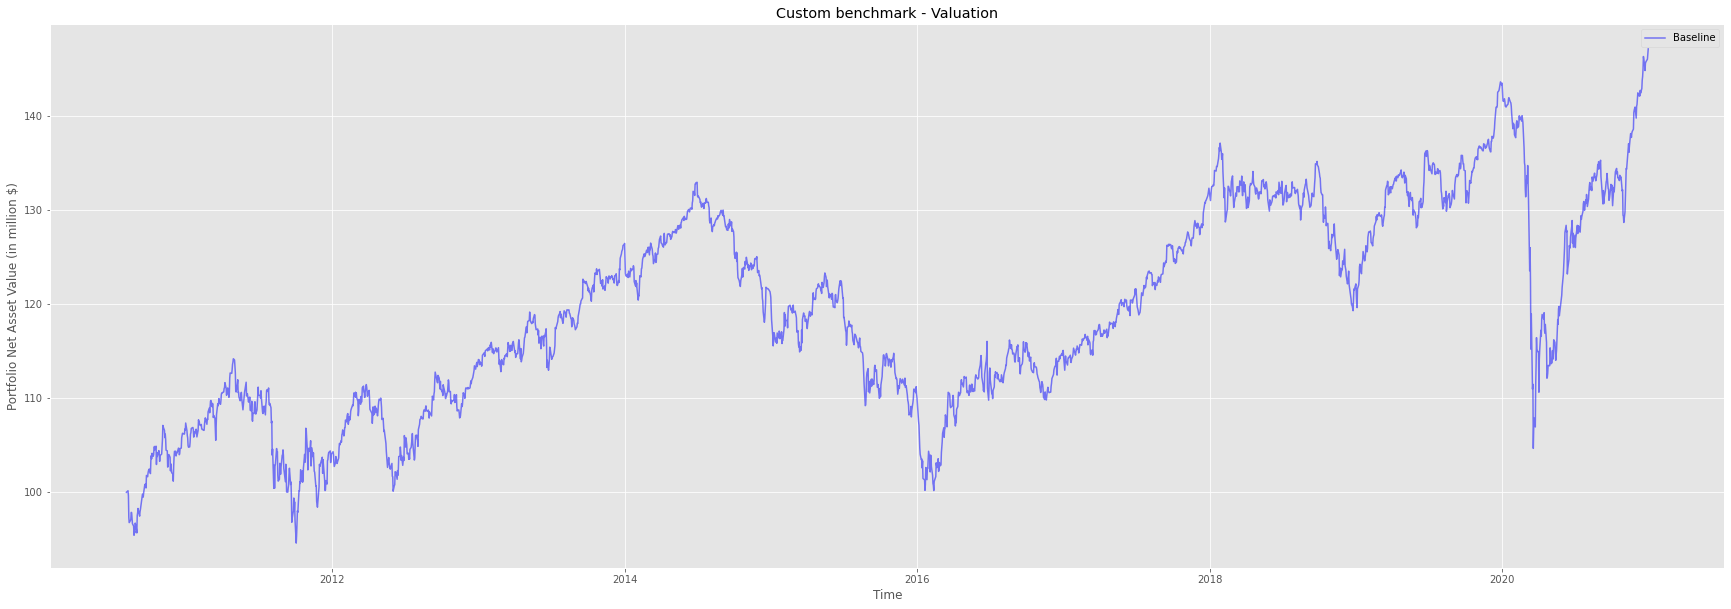

In [11]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(benchmark_val, color = "blue", alpha = 0.5, label = benchmark_portfolio.target)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("Custom benchmark - Valuation")
plt.show()

# Retrospective Portifolio

In [12]:
retrospective_portfolio = Portfolio(target="Retrospective Portfolio",
                        tickerset= ticker_set, investment= 100,
                        trading_algo= "retrospective_sharpe_Algo", rebalance=1)

retrospective_portfolio.trading_algo.init_params(ticker_list= portfolio_tickers, lever=0.3)
retrospective_portfolio.echo()

Building Portfolios and Initialising Trading Algorithms
[*********************100%***********************]  5 of 5 completed
Restricted license - for non-production use only - expires 2022-01-13
Target Index: Retrospective Portfolio
Trading Algorithm: Retrospective Max Weights
Starting Investment: 100
Current Investment: 100


In [13]:
retrospective_val = pd.Series([], dtype=float)
retrospective_returns = pd.Series([], dtype=float)

retrospective_weights = pd.DataFrame(index = portfolio_tickers, dtype=float)

for date in stock_data.index:
    tmpdf = stock_data.loc[date]
    tmpdf = tmpdf.unstack().T
    valuation, returns =  retrospective_portfolio.run(date= date, price= tmpdf, tickerlist = portfolio_tickers)
    if (valuation, returns) == (-1,-1):
        print(retrospective_val.index[-1],date.date(), valuation, returns)
        continue
    retrospective_val[date] = valuation
    retrospective_returns[date] = returns
    retrospective_weights[date] = retrospective_portfolio.weights

Reconstitution on: 05-Aug-2010
	Rebalancing on: 05-Aug-2010
	Rebalancing on: 01-Sep-2010
	Rebalancing on: 01-Oct-2010
	Rebalancing on: 01-Nov-2010
	Rebalancing on: 01-Dec-2010
	Rebalancing on: 03-Jan-2011
	Rebalancing on: 01-Feb-2011
	Rebalancing on: 01-Mar-2011
	Rebalancing on: 01-Apr-2011
	Rebalancing on: 02-May-2011
	Rebalancing on: 01-Jun-2011
	Rebalancing on: 01-Jul-2011
	Rebalancing on: 01-Aug-2011
	Rebalancing on: 01-Sep-2011
	Rebalancing on: 03-Oct-2011
	Rebalancing on: 01-Nov-2011
	Rebalancing on: 01-Dec-2011
	Rebalancing on: 03-Jan-2012
	Rebalancing on: 01-Feb-2012
	Rebalancing on: 01-Mar-2012
	Rebalancing on: 02-Apr-2012
	Rebalancing on: 01-May-2012
	Rebalancing on: 01-Jun-2012
	Rebalancing on: 02-Jul-2012
	Rebalancing on: 01-Aug-2012
	Rebalancing on: 04-Sep-2012
	Rebalancing on: 01-Oct-2012
	Rebalancing on: 01-Nov-2012
	Rebalancing on: 03-Dec-2012
	Rebalancing on: 02-Jan-2013
	Rebalancing on: 01-Feb-2013
	Rebalancing on: 01-Mar-2013
	Rebalancing on: 01-Apr-2013
	Rebalancing

<AxesSubplot:>

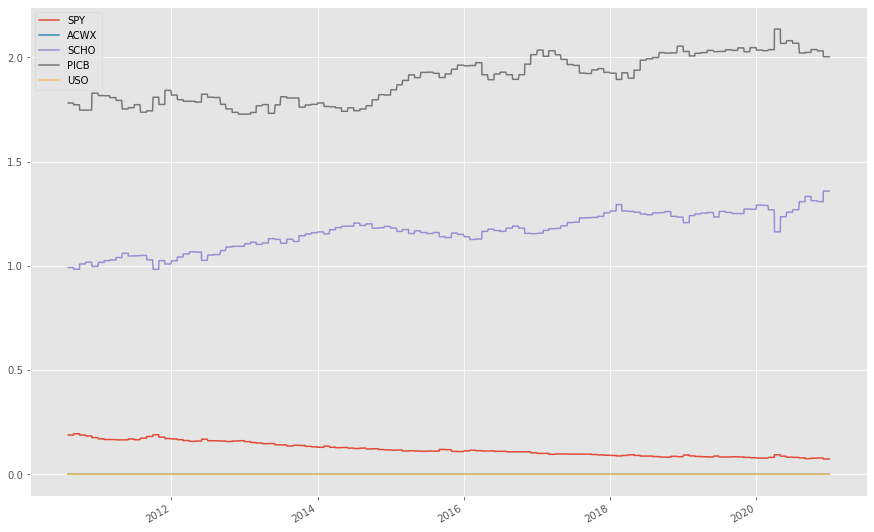

In [14]:
retrospective_weights.T.plot(figsize=(15,10))

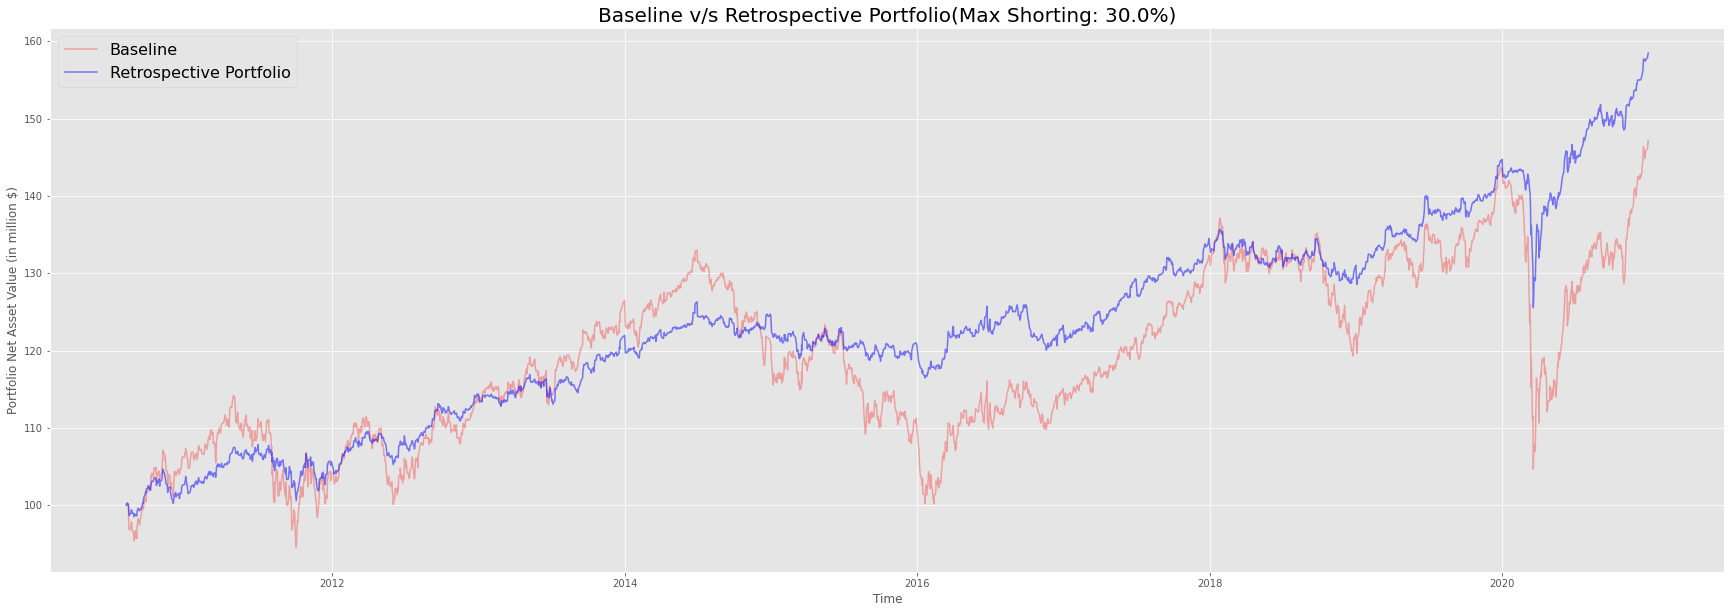

In [15]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(benchmark_val, color = "red", alpha = 0.3, label = benchmark_portfolio.target)
plt.plot(retrospective_val, color = "blue", alpha = 0.5, label = retrospective_portfolio.target)
plt.legend(fontsize = 16)
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("Baseline v/s Retrospective Portfolio(Max Shorting: {short}%)".format(short = retrospective_portfolio.trading_algo.max_leverage*100), fontsize = 20)
plt.show()

# Efficient Portfolio

In [16]:
sharpe_lookback = "3 Y"
stock_data = stock_data[stock_data.index > (stock_data.index[0] +  pd.Timedelta(sharpe_lookback))]

In [17]:
maxsharpe_portfolio = Portfolio(target="Efficient Portfolio",
                        tickerset= ticker_set, investment= benchmark_val[stock_data.index[0]],
                        trading_algo= "capm_Algo", rebalance=1)

maxsharpe_portfolio.trading_algo.init_params(lever = 0.3, lookback = sharpe_lookback)
maxsharpe_portfolio.echo()

Building Portfolios and Initialising Trading Algorithms
Target Index: Efficient Portfolio
Trading Algorithm: CAPM Weights
Starting Investment: 119.11485450007055
Current Investment: 119.11485450007055


In [18]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

portfolio_weights = pd.DataFrame(index = portfolio_tickers, dtype=float)

for date in stock_data.index:
    tmpdf = stock_data.loc[date]
    tmpdf = tmpdf.unstack().T
    valuation, returns =  maxsharpe_portfolio.run(date= date, price= tmpdf, tickerlist = portfolio_tickers)
    if (valuation, returns) == (-1,-1):
        print(portfolio_val.index[-1],date.date(), valuation, returns)
        continue
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns
    portfolio_weights[date] = maxsharpe_portfolio.weights

Reconstitution on: 05-Aug-2013
	Rebalancing on: 05-Aug-2013
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 03-Sep-2013
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 01-Oct-2013
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 01-Nov-2013
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 02-Dec-2013
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 02-Jan-2014
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 03-Feb-2014
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 03-Mar-2014
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 01-Apr-2014
[*********************100%***********************]  5 of 5 completed
	Rebalancing on: 01-May-2014
[*********************100%***********************]  5 of 5

<AxesSubplot:>

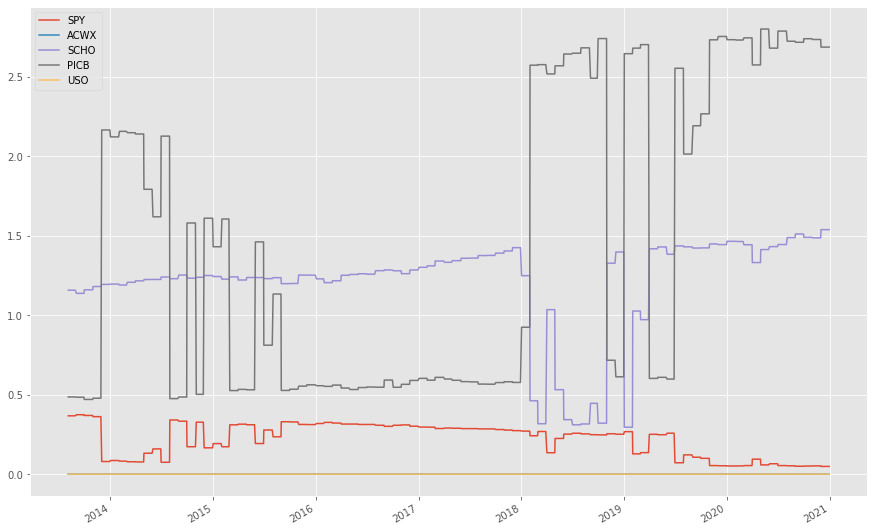

In [19]:
portfolio_weights.T.plot(figsize=(15,10))

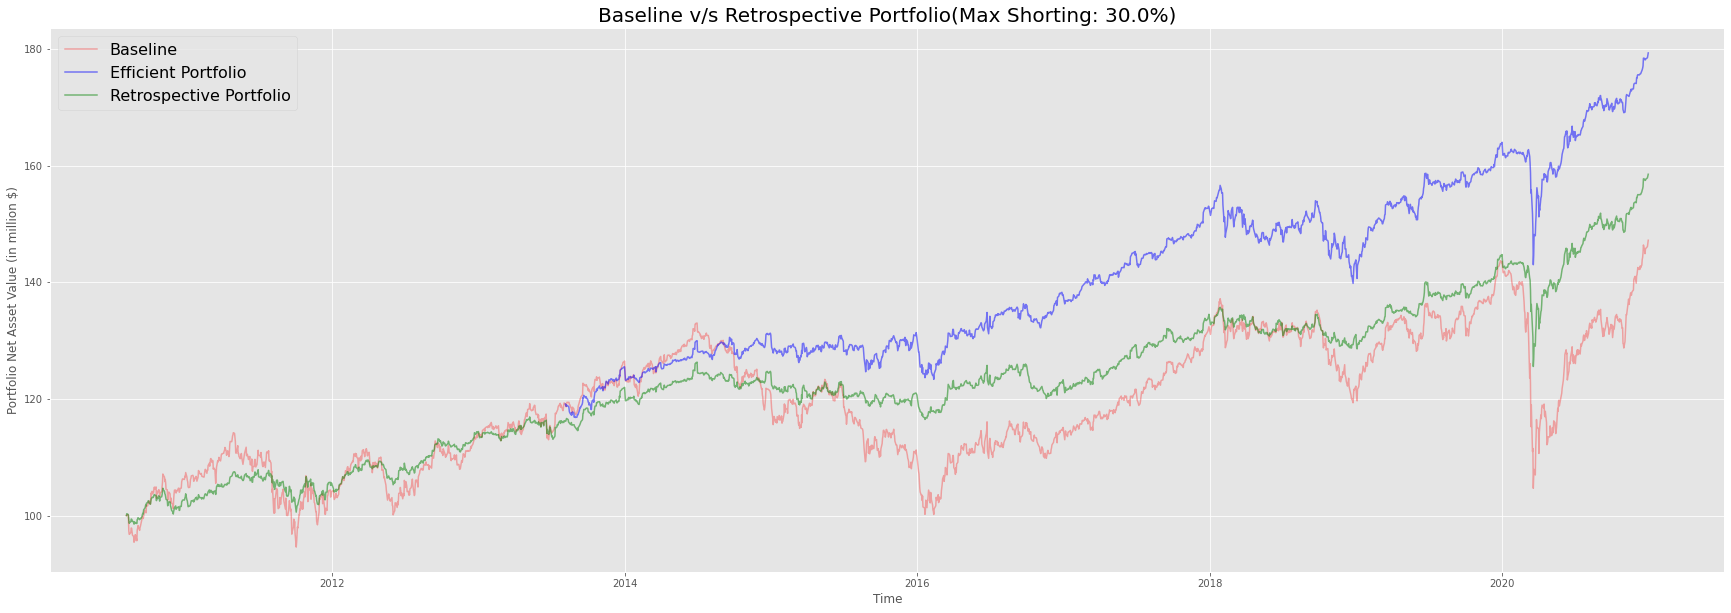

In [20]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(benchmark_val, color = "red", alpha = 0.3, label = benchmark_portfolio.target)
plt.plot(portfolio_val, color = "blue", alpha = 0.5, label = maxsharpe_portfolio.target)
plt.plot(retrospective_val, color = "green", alpha = 0.5, label = retrospective_portfolio.target)
plt.legend(fontsize = 16)
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("Baseline v/s Retrospective Portfolio(Max Shorting: {short}%)".format(short = maxsharpe_portfolio.trading_algo.max_leverage*100), fontsize = 20)
plt.show()

# S&P500 Portfolio

## Read S&P 500 Index Constituent Data

- WRDS Method _(includes historical data)_

In [ ]:
spy_ticker_data = pd.read_csv("./data/sp500_constituents.csv")
spy_ticker_set = set(spy_ticker_data["Symbol"])
print("Unique Indices:",len(spy_ticker_set))
spy_ticker = dict()
for year in spy_ticker_data["Year"].unique():
    spy_ticker[year] = list(spy_ticker_data[spy_ticker_data["Year"] == year]["Symbol"])
# spy_ticker

Fetch data from WRDS using the  list

***

## Read Daily Stock data from WRDS


### Desciption:

- GVKEY: Company Code ?
- IID  : Issue ID - Dividents ?
- DATADATE: Date
- TIC: Company Ticker
- CUSIP: Company CUSIP Code
- CONM : Company Name
- CSHOC : Shares Outstanding
- CSHTRD : Trading Volume
- PRCCD : Price Close Daily
- PRCHD : Price High Daily
- PRCLD : Price Low Daily
- PRCOD : Price Open Daily
- TRFD  : Total Return Factor Daily
- EXCHG : Stock Exchange Code
- BUSDESC : S&P Business Description
- GGROUP : GIC Groups
- GIND : GIC Industries
- GSECTOR : GIC Sector
- GSUBIND : GIC Sub-Industry

**Looking at stocks since 01 Jan 2010**

In [ ]:
spy_dataframe = data[data["datadate"] >= pd.to_datetime("01-01-2010")]

# Temporay measure b/c our spy_ticker does not have 2021 data
spy_dataframe = data[data["datadate"] <= pd.to_datetime("01-01-2021")]
print("Number of unique tickers:",len(spy_dataframe.tic.value_counts()))
spy_data = spy_dataframe[["datadate","tic","div","shares","close"]].reset_index(drop=True)
print("Dimensions: ",spy_data.shape)
print(spy_data.isna().sum())
spy_data[np.isnan(spy_data.close)]

**Removing 29 Oct 2012 b/c everything is NaN. so portfolio becomes Nan**

Just a couple of Nan values in close.
Should not affect quaterly averages.

In [ ]:
spy_data.drop(index = spy_data[spy_data.close.isna()].index, inplace=True)
print(spy_data.isna().sum())

In [ ]:
spy_data = spy_data.set_index(["datadate","tic"])
spy_data

In [ ]:
market_calendar_dates = sorted(list(set(map(lambda x: x[0],spy_data.index.values))))
market_calendar_dates[0:5]

## Executing Portfolio

In [ ]:
;
%run -i 'portfolio.py'

In [ ]:
# spy_trading_algo = SNP500_Algo("S&P 500 Algo")
spy_portfolio = Portfolio(target="S&P 500",
                        tickerset= [], investment= 1000000,
                        trading_algo= "SNP500_Algo",
                        rebalance=4, reconstitute=12)

spy_portfolio.echo()

In [ ]:
portfolio_val = pd.Series([], dtype=float)
portfolio_returns = pd.Series([], dtype=float)

for date in market_calendar_dates:
    tmpdf = spy_data.loc[date,:]
    valuation, returns =  spy_portfolio.run(date= date, price= tmpdf, tickerlist = spy_ticker[date.year])
    if (valuation, returns) == (-1,-1):
        print(portfolio_val.index[-1],date.date(), valuation, returns)
        continue
    portfolio_val[date] = valuation
    portfolio_returns[date] = returns

In [ ]:
spy_portfolio.echo()
# print("Net return since start: ",spy_portfolio.net_return()*100,"%")

In [ ]:
from scipy.stats.mstats import gmean
print("daily return: ",(gmean(portfolio_returns.fillna(1)+1)-1)*100,"%")

## S&P Index, ETF and Mutual Fund

In [ ]:
benchmark_data = yf.download("^GSPC SPY VFIAX", start="2010-01-01", end="2020-12-31")
benchmark_data = benchmark_data["Close"]#.loc[portfolio_returns.index]
benchmark_data.head()

In [ ]:
baseline_return = benchmark_data.apply(daily_returns).fillna(0)
baseline_return.head()

## Plot

In [ ]:
fig, ax = plt.subplots(1,2, sharex= False, sharey=False)
fig.set_size_inches(30, 10,  forward=True)

ax[0].plot(portfolio_val)
ax[0].plot(benchmark_data["^GSPC"]*900)
ax[0].plot(benchmark_data["SPY"]*8961.3)
ax[0].plot(benchmark_data["VFIAX"]*9600)
ax[0].legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Portfolio Net Asset Value (in million $)")
ax[0].set_title("Portfolio v/s benchmarks - Valuation")

ax[1].plot(portfolio_returns)
ax[1].plot(baseline_return["^GSPC"])
ax[1].plot(baseline_return["SPY"])
ax[1].plot(baseline_return["VFIAX"])
ax[1].legend(["Portfolio Returns","^GSPC","SPY","VFIAX"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Portfolio Daily Returns")
ax[1].set_title("Portfolio v/s benchmarks - Returns")

fig.suptitle('S&P 500 Replicating Portfolio',fontsize=20);

In [ ]:
tracking_error_spy = baseline_return.apply(lambda x: (tracking_error(portfolio_returns,x)))
for index, value in tracking_error_spy.iteritems():
    print("Tracking error between our portfolio and {target} is {std}%".format(target = index, std = str(round(value,5)*100)))

In [ ]:
plt.figure().set_size_inches(30, 10,  forward=True)

plt.plot(portfolio_val)
plt.plot(benchmark_data["^GSPC"]*900)
plt.plot(benchmark_data["SPY"]*8961.3)
plt.plot(benchmark_data["VFIAX"]*9600)
plt.legend(["Portfolio Value","^GSPC","SPY","VFIAX"])
plt.xlabel("Time")
plt.ylabel("Portfolio Net Asset Value (in million $)")
plt.title("S&P 500 Portfolio v/s benchmarks - Valuation")
plt.show()

***
***